In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

from tqdm.notebook import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model


from matplotlib.offsetbox import OffsetImage, AnnotationBbox

PATH = Path('../..').resolve()

seed = 12345

%matplotlib inline

In [2]:
sys.path.append(f'{PATH}/src')

from mxresnet import *
from ranger import Ranger

slope = lambda y, p: ((y-y.mean())*(p-p.mean())).sum()/((y-y.mean())**2).sum()

Mish activation loaded...
Mish activation loaded...


In [3]:
xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

tfms = get_transforms(
    do_flip=True,
    flip_vert=True,
    max_zoom=1.0,
    max_rotate=15.0,
    max_lighting=0,
    max_warp=0,
)

# Retrieve $\alpha$.40 trained model
(See also notebooks `01` and `03`)

In [4]:
df = pd.read_csv(f"{PATH}/data/a40-SDSS_gas-frac.csv")

In [5]:
src = (
    ImageList.from_df(
        df, path=PATH, folder="images-OC", suffix=".jpg", cols="AGCNr"
    )
    .split_by_rand_pct(0.2, seed=seed)
    .label_from_df(cols=["logfgas"], label_cls=FloatList)
)

data = (
    src.transform(tfms, size=224)
    .databunch(bs=32)
    .normalize(xGASS_stats)
)

In [6]:
model = mxresnet50()
model[-1] = nn.Linear(model[-1].in_features, 1, bias=True)

In [7]:
learn = Learner(
    data,
    model=model,
    opt_func=partial(Ranger),
    loss_func=root_mean_squared_error,
    wd=1e-3,
    bn_wd=False,
    true_wd=True,
)

In [8]:
learn = learn.load('best_a40A-50');

set state called


# Get activations for model trained on $\alpha$.40 SDSS images
(See also [the dimensionality reduction notebook(s)](https://nbviewer.jupyter.org/github/jwuphysics/HI-diversity/blob/master/notebook/02.%20Mapping%20optical%20morphology%20to%20PCA%20or%20t-SNE%20space.ipynb))

In [12]:
m = learn.model.eval();

In [10]:
N_train = len(data.train_ds)


train_acts = np.zeros(shape=(N_train, 2048))

# grab all activations for training set
for i, fn in tqdm(enumerate(data.train_dl.items), total=N_train):
    img = open_image(fn);
        
    # get single item
    X, _ = data.one_item(img)
    
    # save activations before final linear layer
    with hook_output(model[-2]) as hook_a:
        pred = m(X.cuda())
    
        train_acts[i] = hook_a.stored[0].cpu().numpy()

In [11]:
N_valid = len(data.valid_ds)


valid_acts = np.zeros(shape=(N_valid, 2048))

# grab all activations for training set
for i, fn in tqdm(enumerate(data.valid_dl.items), total=N_valid):
    img = open_image(fn);
        
    # get single item
    X, _ = data.one_item(img)
    
    # save activations before final linear layer
    with hook_output(model[-2]) as hook_a:
        pred = m(X.cuda())
    
        valid_acts[i] = hook_a.stored[0].cpu().numpy()

# PCA: reduce to 10 dimensions

In [14]:
# pca = PCA(n_components=10, random_state=seed)
# train_acts_PCA = pca.fit_transform(train_acts)

# np.save(f'{PATH}/results/confidence/train_acts_PCA-a40.npy', train_acts_PCA)

In [15]:
# # save PCA
# with open(f'{PATH}/results/confidence/PCA-model_train_acts-a40.pkl', 'wb') as f:
#     pickle.dump(pca, f)

In [16]:
# valid_acts_PCA = pca.transform(valid_acts)

# np.save(f'{PATH}/results/confidence/valid_acts_PCA-a40.npy', valid_acts_PCA)

In [9]:
with open(f'{PATH}/results/confidence/PCA-model_train_acts-a40.pkl', 'rb') as f:
    pca = pickle.load(f)

train_acts_PCA = np.load(f'{PATH}/results/confidence/train_acts_PCA-a40.npy')
valid_acts_PCA = np.load(f'{PATH}/results/confidence/valid_acts_PCA-a40.npy')

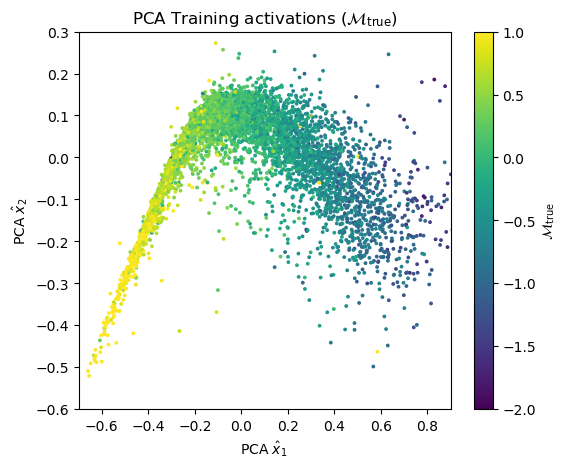

In [27]:
plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(train_acts_PCA[:, 0], train_acts_PCA[:, 1], c=data.train_ds.y.items, vmin=-2, vmax=1, s=3)

cb = plt.colorbar()

plt.title(f'PCA Training activations ' r'($\mathcal{M}_{\rm true}$)')
cb.set_label(r'$\mathcal{M}_{\rm true}$')
plt.xlabel(r'PCA $\hat x_1$')
plt.ylabel(r'PCA $\hat x_2$')

plt.xlim(-0.7, 0.9)
plt.ylim(-0.6, 0.3)

plt.show()


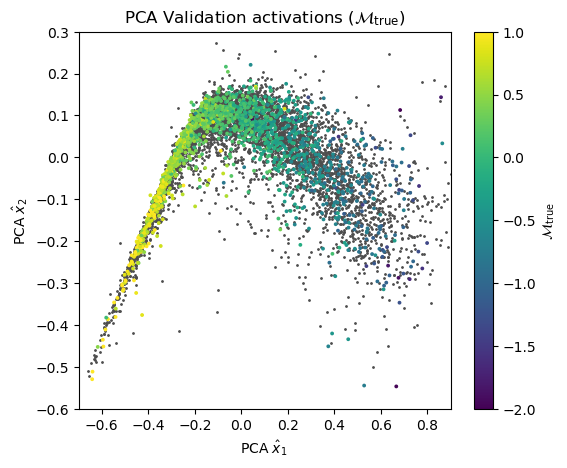

In [28]:
plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(train_acts_PCA[:, 0], train_acts_PCA[:, 1], c='0.3', s=1)

plt.scatter(valid_acts_PCA[:, 0], valid_acts_PCA[:, 1], c=data.valid_ds.y.items, vmin=-2, vmax=1, s=3)

cb = plt.colorbar()

plt.title(f'PCA Validation activations ' r'($\mathcal{M}_{\rm true}$)')
cb.set_label(r'$\mathcal{M}_{\rm true}$')
plt.xlabel(r'PCA $\hat x_1$')
plt.ylabel(r'PCA $\hat x_2$')

plt.xlim(-0.7, 0.9)
plt.ylim(-0.6, 0.3)

plt.show()


## Look at $\Delta \mathcal{M}$

In [29]:
a40 = pd.read_csv(f'{PATH}/results/predictions/best_a40A-34.csv')


delta_fgas = a40.fgas_pred - a40.fgas_true

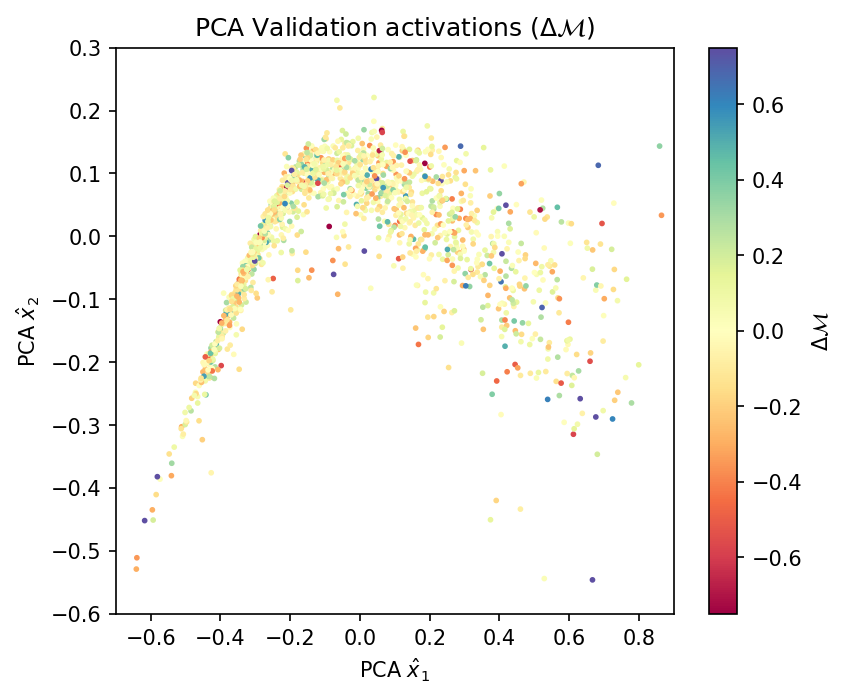

In [32]:
plt.figure(figsize=(6, 5), dpi=150)
# plt.scatter(train_acts_PCA[:, 0], train_acts_PCA[:, 1], c='0.3', s=1)

plt.scatter(valid_acts_PCA[:, 0], valid_acts_PCA[:, 1], c=delta_fgas, vmin=-0.75, vmax=0.75, s=3, cmap='Spectral')

cb = plt.colorbar()

plt.title(f'PCA Validation activations ' r'($\Delta\mathcal{M}$)')
cb.set_label(r'$\Delta\mathcal{M}$')
plt.xlabel(r'PCA $\hat x_1$')
plt.ylabel(r'PCA $\hat x_2$')

plt.xlim(-0.7, 0.9)
plt.ylim(-0.6, 0.3)

plt.show()


# Using activations to compare with xGASS

In [10]:
xg = pd.read_csv(f"{PATH}/data/xGASS_representative_sample.csv")

data_xg = (
        ImageList.from_df(
            xg, path=PATH, folder="images-xGASS", suffix=".jpg", cols="GASS"
        )
        .split_none()
        .label_from_df(cols=["lgGF"], label_cls=FloatList)
    .transform(tfms, size=224)
    .databunch(bs=32)
    .normalize(xGASS_stats)
)


In [13]:
N_xg = len(data_xg.train_ds)


xg_acts = np.zeros(shape=(N_xg, 2048))

# grab all activations for training set
for i, fn in tqdm(enumerate(data_xg.train_dl.items), total=N_xg):
    img = open_image(fn);
        
    # get single item
    X, _ = data_xg.one_item(img)
    
    # save activations before final linear layer
    with hook_output(model[-2]) as hook_a:
        pred = m(X.cuda())
    
        xg_acts[i] = hook_a.stored[0].cpu().numpy()

In [ ]:
xg_acts_PCA = pca.transform(xg_acts)

np.save(f'{PATH}/results/confidence/acts_PCA-xGASS.npy', xg_acts_PCA)

## Visualizing comparisons of xGASS and $\alpha$.40

In [35]:
a40_acts_PCA = pca.transform(valid_acts)

### PCs 1&2

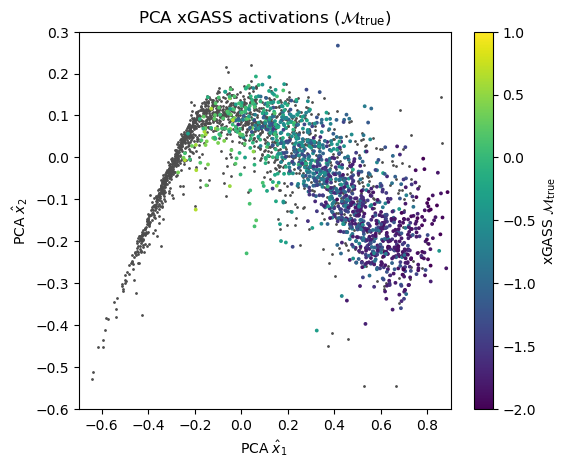

In [37]:
plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(a40_acts_PCA[:, 0], a40_acts_PCA[:, 1], c='0.3', s=1)

plt.scatter(xg_acts_PCA[:, 0], xg_acts_PCA[:, 1], c=data_xg.train_ds.y.items, vmin=-2, vmax=1, s=3)

cb = plt.colorbar()

plt.title(f'PCA xGASS activations ' r'($\mathcal{M}_{\rm true}$)')
cb.set_label(r'xGASS $\mathcal{M}_{\rm true}$')
plt.xlabel(r'PCA $\hat x_1$')
plt.ylabel(r'PCA $\hat x_2$')

plt.xlim(-0.7, 0.9)
plt.ylim(-0.6, 0.3)

plt.show()


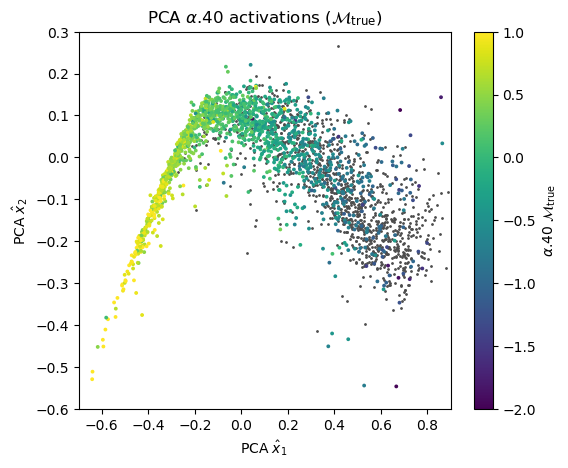

In [47]:
plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(xg_acts_PCA[:, 0], xg_acts_PCA[:, 1], c='0.3', s=1)

plt.scatter(a40_acts_PCA[:, 0], a40_acts_PCA[:, 1], c=data.valid_ds.y.items, vmin=-2, vmax=1, s=3)


cb = plt.colorbar()

plt.title(r'PCA $\alpha$.40 activations ' r'($\mathcal{M}_{\rm true}$)')
cb.set_label(r'$\alpha$.40 $\mathcal{M}_{\rm true}$')
plt.xlabel(r'PCA $\hat x_1$')
plt.ylabel(r'PCA $\hat x_2$')

plt.xlim(-0.7, 0.9)
plt.ylim(-0.6, 0.3)

plt.show()


### PCs 1 & 3

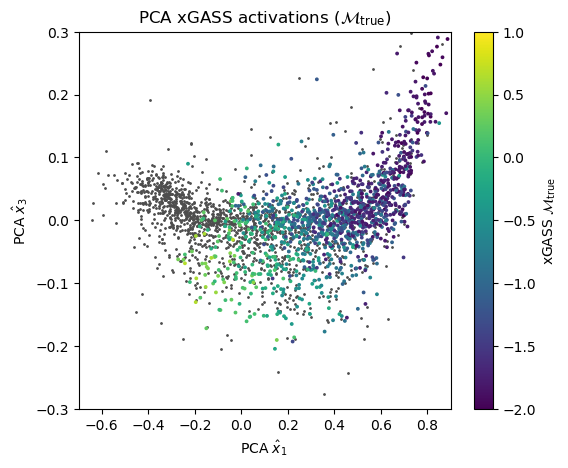

In [143]:
plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(a40_acts_PCA[:, 0], a40_acts_PCA[:, 2], c='0.3', s=1)

plt.scatter(xg_acts_PCA[:, 0], xg_acts_PCA[:, 2], c=data_xg.train_ds.y.items, vmin=-2, vmax=1, s=3)

cb = plt.colorbar()

plt.title(f'PCA xGASS activations ' r'($\mathcal{M}_{\rm true}$)')
cb.set_label(r'xGASS $\mathcal{M}_{\rm true}$')
plt.xlabel(r'PCA $\hat x_1$')
plt.ylabel(r'PCA $\hat x_3$')

plt.xlim(-0.7, 0.9)
plt.ylim(-0.3, 0.3)

plt.show()


### Corner plot of first 5 PCs

In [145]:
pca.explained_variance_ratio_

array([0.78466 , 0.115776, 0.043783, 0.015203, 0.009968, 0.005831, 0.005006, 0.003941, 0.002288, 0.001608])

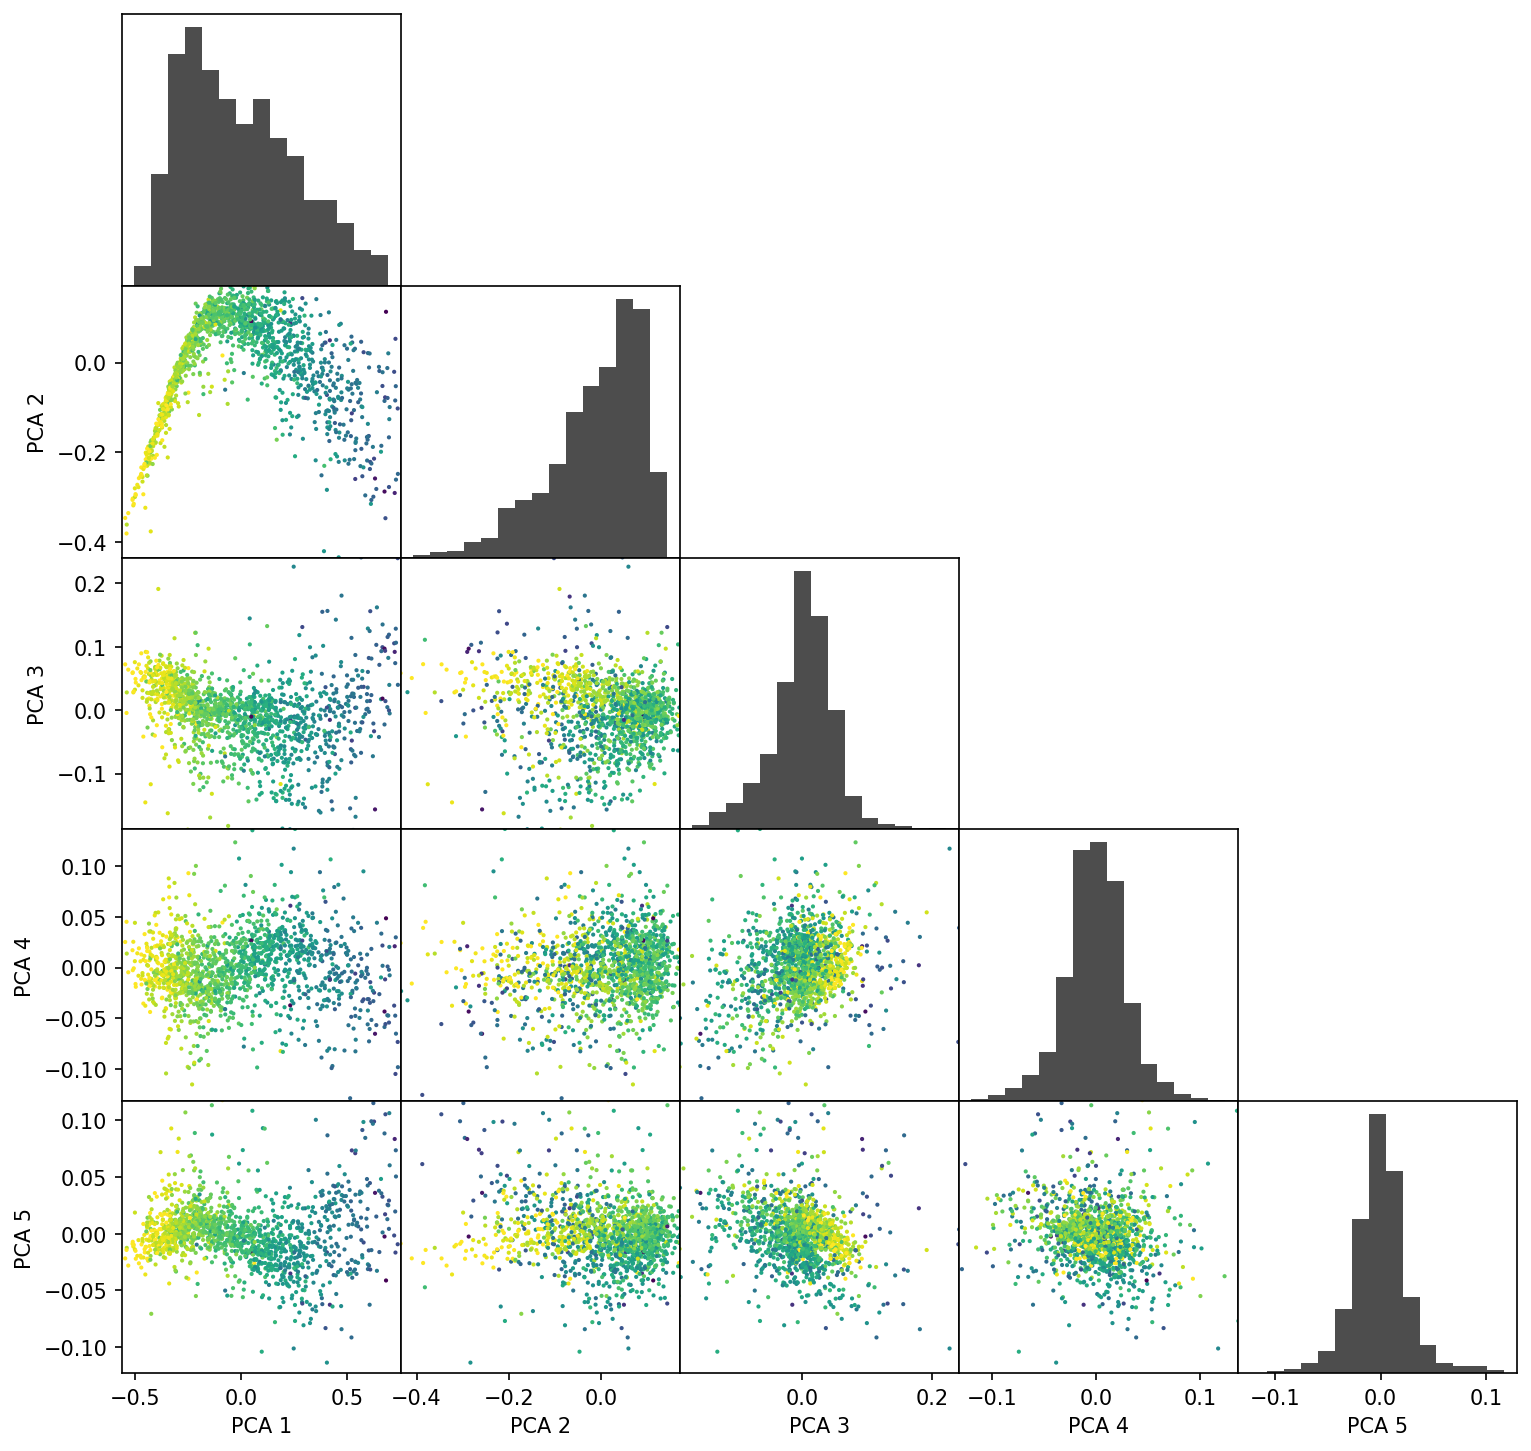

In [185]:
fig = plt.figure(figsize=(12, 12), dpi=150)
fig.subplots_adjust(hspace=0, wspace=0)

plt.title(r'PCs for $\alpha$.40')

for i in range(5):
    for j in range(5):
        if i <= j:
            plt.subplot(5,5,i+j*5+1)
            if i == 0 and j != 0:
                plt.ylabel(f'PCA {j+1}')
            if j == 4:
                plt.xlabel(f'PCA {i+1}')
            if i != 0:
                plt.yticks([])
            if j != 4:
                plt.xticks([])
            
            if i < j:
                plt.xlim(*np.quantile(a40_acts_PCA[:,i], [0.005, 0.995]))
                plt.ylim(*np.quantile(a40_acts_PCA[:,j], [0.005, 0.995]))
                
                plt.scatter(a40_acts_PCA[:, i], a40_acts_PCA[:, j], c=a40.fgas_true, vmin=-2, vmax=1, s=1, cmap='viridis')
                
            if i == j:
                plt.hist(a40_acts_PCA[:,i], range=np.quantile(a40_acts_PCA[:,i], [0.005, 0.995]), bins=15, color='0.3')
                plt.yticks([])

plt.show()

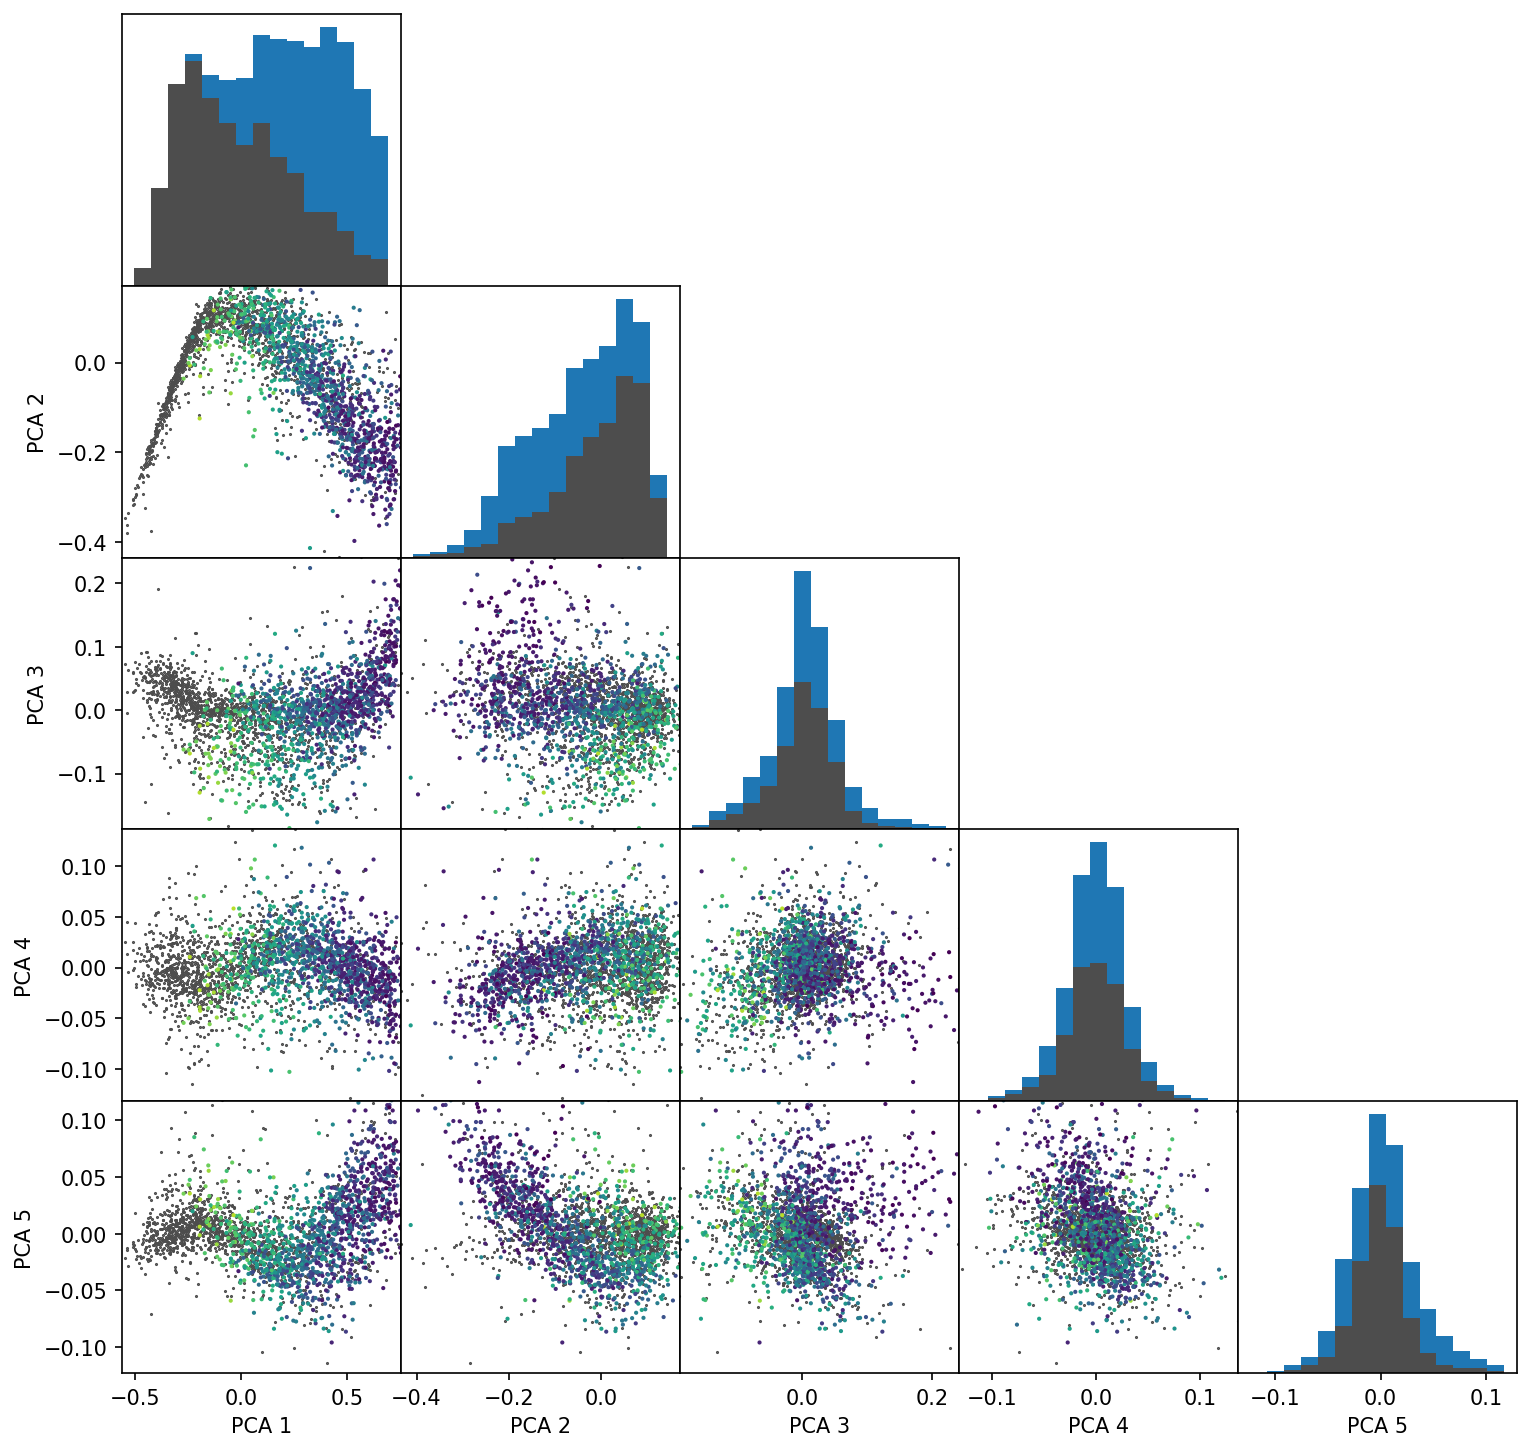

In [186]:
fig = plt.figure(figsize=(12, 12), dpi=150)
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(5):
    for j in range(5):
        if i <= j:
            plt.subplot(5,5,i+j*5+1)
            if i == 0 and j != 0:
                plt.ylabel(f'PCA {j+1}')
            if j == 4:
                plt.xlabel(f'PCA {i+1}')
            if i != 0:
                plt.yticks([])
            if j != 4:
                plt.xticks([])
            
            if i < j:
                plt.xlim(*np.quantile(a40_acts_PCA[:,i], [0.005, 0.995]))
                plt.ylim(*np.quantile(a40_acts_PCA[:,j], [0.005, 0.995]))
                
                plt.scatter(a40_acts_PCA[:,i], a40_acts_PCA[:,j], s=1, marker='.', c='0.3')
                plt.scatter(xg_acts_PCA[:, i], xg_acts_PCA[:, j], c=data_xg.train_ds.y.items, vmin=-2, vmax=1, s=1)
                
            if i == j:
                plt.hist([a40_acts_PCA[:,i], xg_acts_PCA[:, i]], stacked=True, density=True, \
                          range=np.quantile(a40_acts_PCA[:,i], [0.005, 0.995]), bins=15,
                          color=['0.3', 'C0'])
                plt.yticks([])

plt.show()



## Looking at xGASS residuals in corner plot PC space

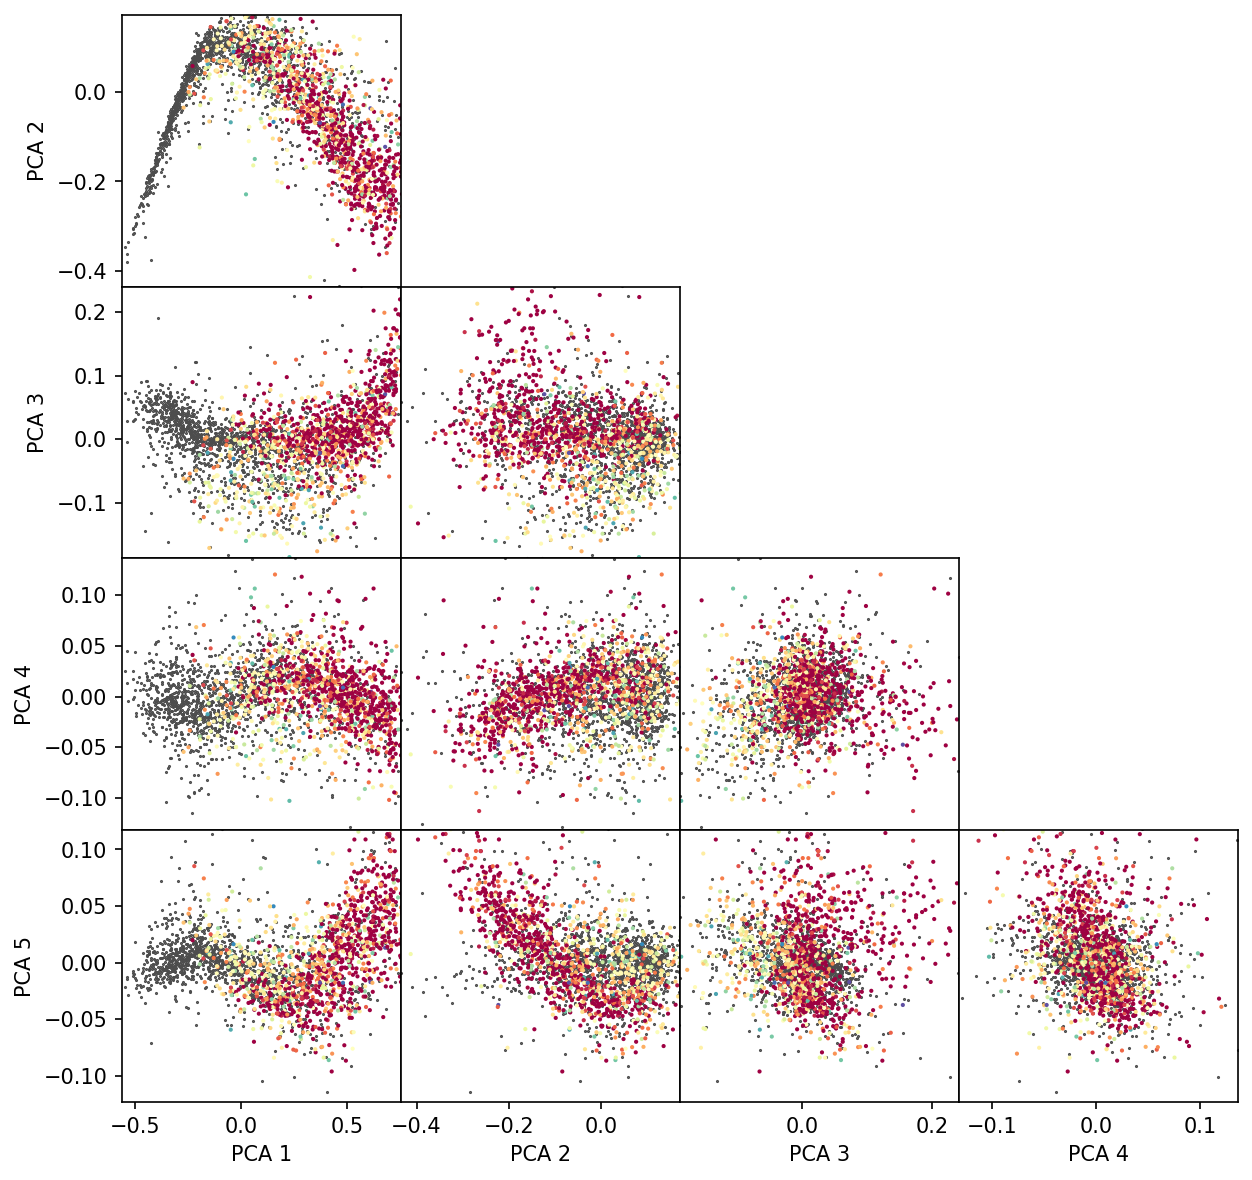

In [279]:
fig = plt.figure(figsize=(12, 12), dpi=150)
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(5):
    for j in range(5):
        if i < j:
            plt.subplot(5,5,i+j*5+1)
            if i == 0 and j != 0:
                plt.ylabel(f'PCA {j+1}')
            if j == 4:
                plt.xlabel(f'PCA {i+1}')
            if i != 0:
                plt.yticks([])
            if j != 4:
                plt.xticks([])
            
            plt.xlim(*np.quantile(a40_acts_PCA[:,i], [0.005, 0.995]))
            plt.ylim(*np.quantile(a40_acts_PCA[:,j], [0.005, 0.995]))

            plt.scatter(a40_acts_PCA[:,i], a40_acts_PCA[:,j], s=1, marker='.', c='0.3')
            plt.scatter(xg_acts_PCA[:, i], xg_acts_PCA[:, j], c=(xg_results[:,0]-xg_results[:,1]), vmin=-0.6, vmax=0.6, s=1, cmap='Spectral_r')


plt.show()



## Checking RMSE along $\hat x_1$ (doesn't work): this data set shift is clearly continuous, but not necessarily along a single PC

Text(0.5, 0, 'PCA $\\hat x_1$')

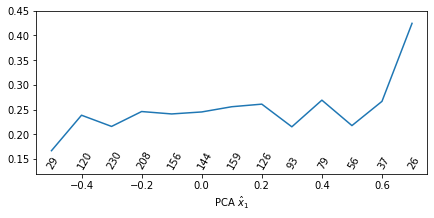

In [129]:
# compute RMSE error for a40 training set along the x1 axis
plt.figure(figsize=(7, 3))

x1_bins = np.arange(-0.5, 0.8, 0.1)
error = []

for x1 in x1_bins:
    within_bin = (a40_acts_PCA[:,0] > x1-0.05) & (a40_acts_PCA[:,0] <= x1+0.05)
    error.append(((a40.fgas_pred - a40.fgas_true)[within_bin]**2).mean()**0.5)
    
    plt.text(x1-0.02, 0.13, str(sum(within_bin)), rotation=60)

plt.plot(x1_bins, error)

plt.xlim(-0.55, 0.75)
plt.ylim(0.12, 0.45)
plt.xlabel(r'PCA $\hat x_1$')

In [122]:
xg_results = np.zeros((len(data_xg.train_ds), 2))

for i, [x,y] in tqdm(enumerate(data_xg.train_ds), total=len(xg_results)):
    p = learn.predict(x)[0]
    xg_results[i] = [float(p.data[0]), float(y.data)]

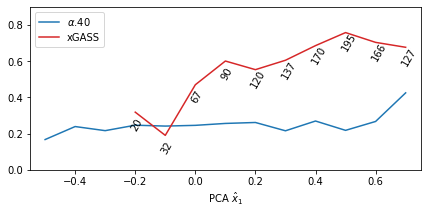

In [140]:
# "validate" RMSE error for xGASS (entire sample) along the x1 axis
plt.figure(figsize=(7, 3))

x1_bins = np.arange(-0.5, 0.8, 0.1)
xg_error = []

for x1 in x1_bins:
    within_bin = (xg_acts_PCA[:,0] > x1-0.05) & (xg_acts_PCA[:,0] <= x1+0.05)
    
    if sum(within_bin) > 1:
        rmse = ((xg_results[:,0] - xg_results[:,1])[within_bin]**2).mean()**0.5
        xg_error.append(rmse)

        plt.text(x1-0.02, rmse-0.1, str(sum(within_bin)), rotation=60)
    else:
        xg_error.append(np.nan)

plt.plot(x1_bins, error, label=r'$\alpha$.40')    
plt.plot(x1_bins, xg_error, label='xGASS', c='C3')

plt.xlim(-0.55, 0.75)
plt.ylim(0., 0.9)
plt.xlabel(r'PCA $\hat x_1$')
plt.legend()

## The PC1 vs PC2 plot shows a star-forming track and a "quiescence" turn-off

Perhaps the star-forming track can be used as a proxy for the latter?

In [251]:
# regress a polynomial to the gas-rich track in PC1 vs PC2

gas_rich = a40_acts_PCA[a40.fgas_true > 0]

X = PolynomialFeatures(degree=2).fit_transform(gas_rich[:,0].reshape(-1, 1))
y = gas_rich[:,1]

reg = linear_model.LinearRegression()
reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [252]:
x1_lin = np.arange(-0.6, 0.8, 0.1)
x2_lin = reg.predict(PolynomialFeatures(degree=2).fit_transform(x1_lin.reshape(-1, 1)))

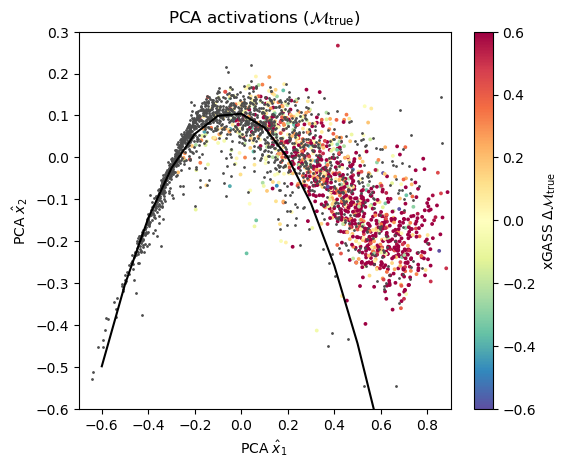

In [268]:
plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(xg_acts_PCA[:, 0], xg_acts_PCA[:, 1], c=(xg_results[:,0]-xg_results[:,1]), vmin=-0.6, vmax=0.6, s=3, cmap='Spectral_r')
cb = plt.colorbar()


plt.scatter(a40_acts_PCA[:, 0], a40_acts_PCA[:, 1],  c='0.3',  s=1)
plt.plot(x1_lin, x2_lin, c='k', label='SF track')


plt.title(r'PCA activations ' r'($\mathcal{M}_{\rm true}$)')
cb.set_label(r'xGASS $\Delta\mathcal{M}_{\rm true}$')
plt.xlabel(r'PCA $\hat x_1$')
plt.ylabel(r'PCA $\hat x_2$')

plt.xlim(-0.7, 0.9)
plt.ylim(-0.6, 0.3)

plt.show()


## Try linear comibinations of PCs

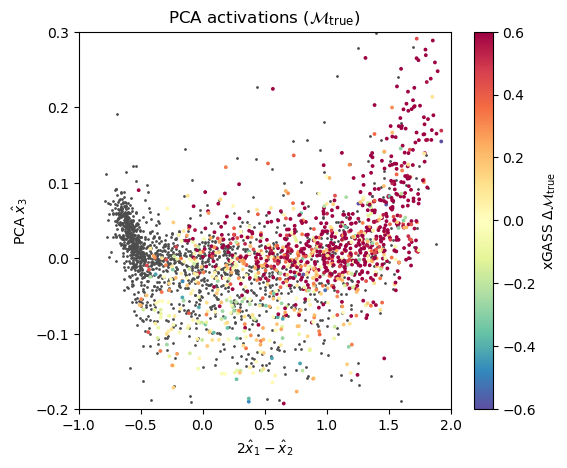

In [369]:
plt.figure(figsize=(6, 5), dpi=100)

vec_0_1 = np.array([2, -1])
vec_2_4 = np.array([1, 0, 0])

plt.scatter(a40_acts_PCA[:, 0:2] @ vec_0_1, a40_acts_PCA[:, 2:5] @ vec_2_4,  c='0.3',  s=1)

plt.scatter(xg_acts_PCA[:, 0:2] @ vec_0_1, xg_acts_PCA[:, 2:5] @ vec_2_4, c=(xg_results[:,0]-xg_results[:,1]), vmin=-0.6, vmax=0.6, s=3, cmap='Spectral_r')
cb = plt.colorbar()


plt.title(r'PCA activations ' r'($\mathcal{M}_{\rm true}$)')
cb.set_label(r'xGASS $\Delta\mathcal{M}_{\rm true}$')
plt.xlabel(r'$2 \hat x_1 - \hat x_2$')
plt.ylabel(r'PCA $\hat x_3$')

plt.xlim(-1, 2)
plt.ylim(-0.2, 0.3)

plt.show()


# t-SNE on PCA-reduced activations (just for fun)

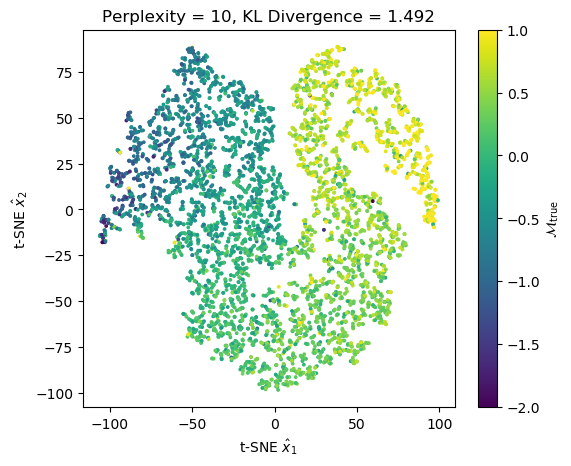

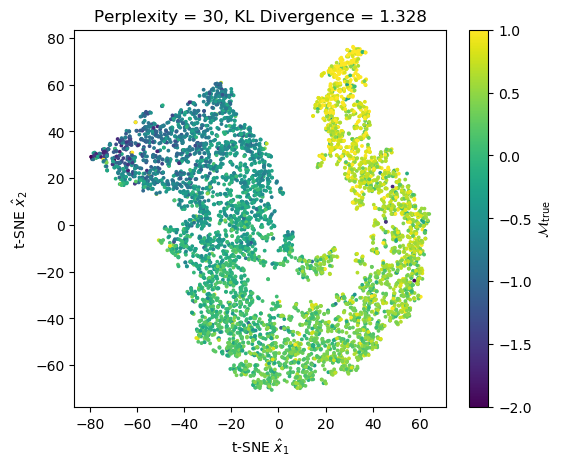

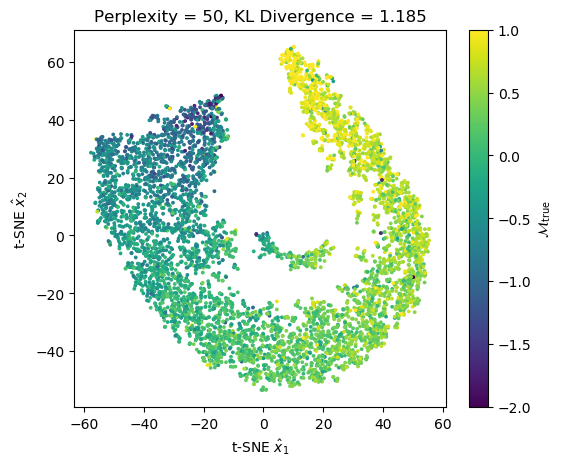

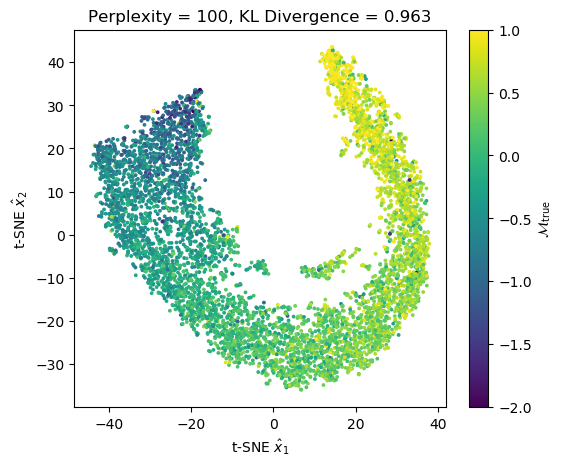

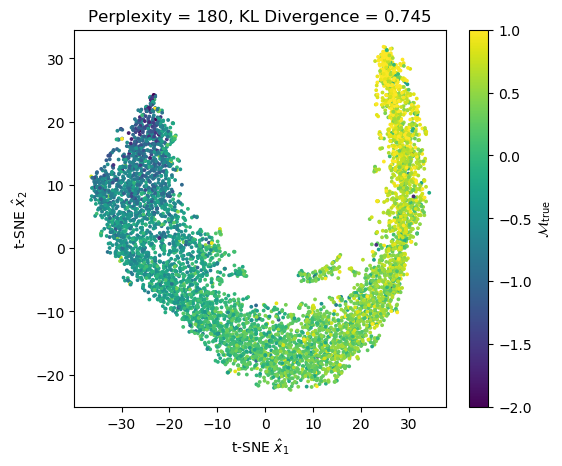

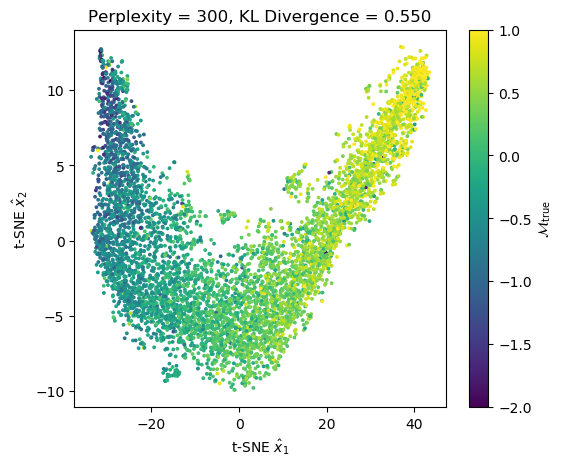

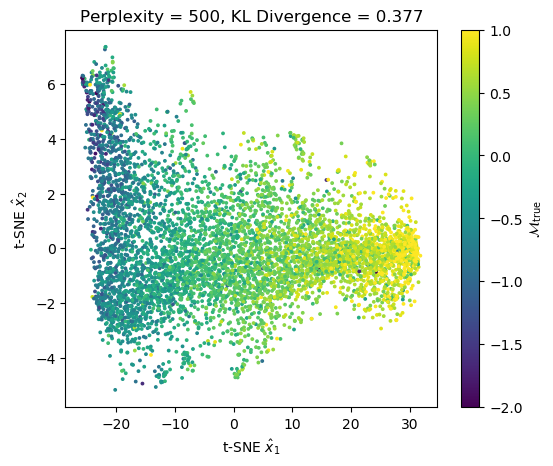

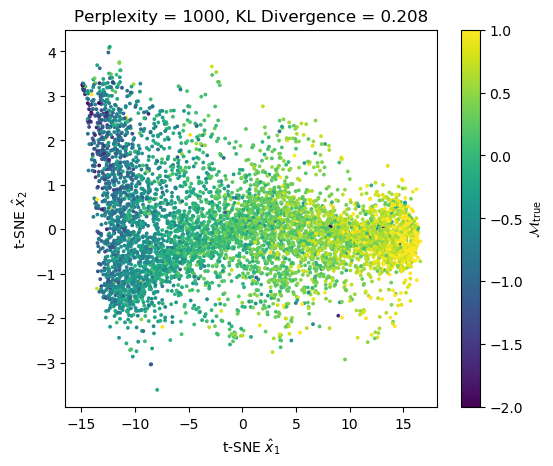

In [70]:
for perplexity in [10, 30, 50, 100, 180, 300, 500, 1000]:
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=seed)
    valid_acts_tsne = tsne.fit_transform(valid_acts_PCA)

    plt.figure(figsize=(6, 5), dpi=100)
    plt.scatter(valid_acts_tsne[:, 0], valid_acts_tsne[:, 1], c=data.train_ds.y.items, vmin=-2, vmax=1, s=3)

    cb = plt.colorbar()

    plt.title(f'Perplexity = {perplexity}, KL Divergence = {tsne.kl_divergence_:.3f}')
    cb.set_label(r'$\mathcal{M}_{\rm true}$')
    plt.xlabel(r't-SNE $\hat x_1$')
    plt.ylabel(r't-SNE $\hat x_2$')

    plt.show()


In [74]:
# with open(f'{PATH}/results/confidence/tSNE-perplexity1000-model_valid_acts-a40.pkl', 'wb') as f:
#     pickle.dump(tsne, f)